Training Data:
 Accuracy (Shared Covariance): 0.5597
 Accuracy (Different Covariances): 0.8806


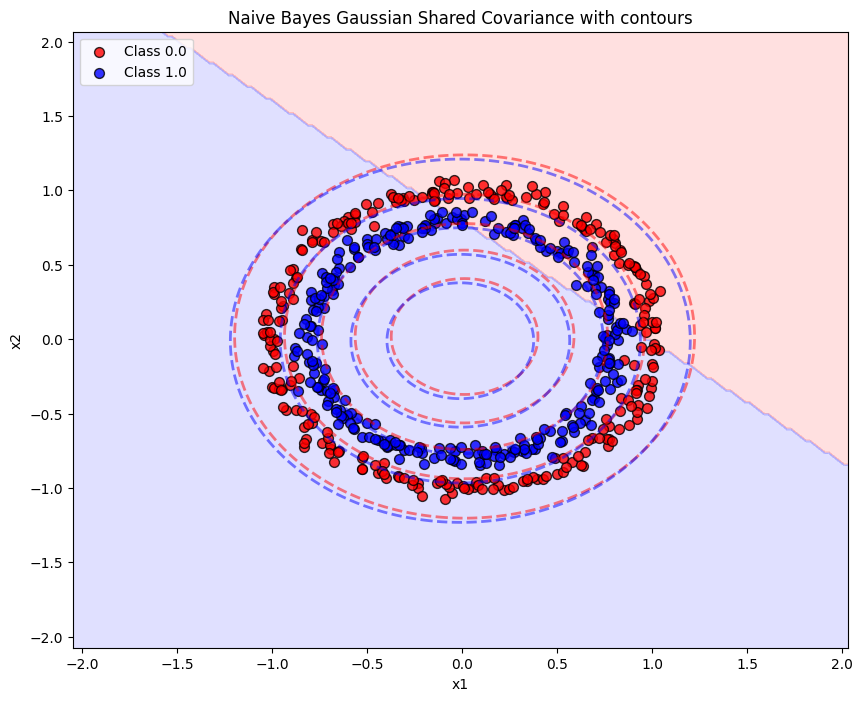

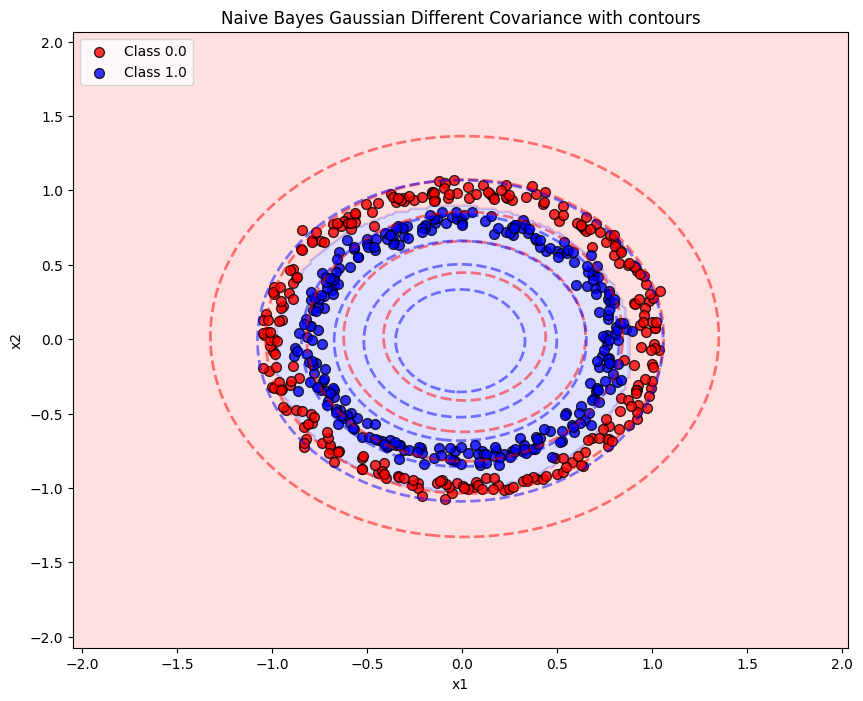

<Figure size 500x500 with 0 Axes>

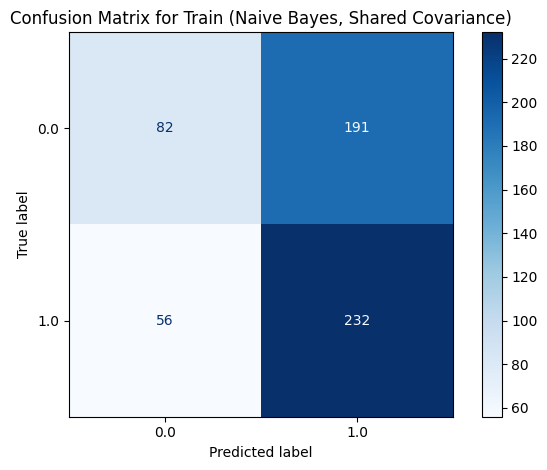

<Figure size 500x500 with 0 Axes>

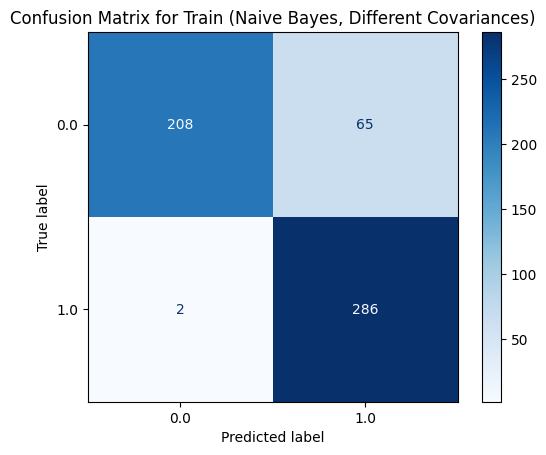

In [9]:
#DATASET 2 NAIVE BAYES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class NaiveBayesClassifier:
    def __init__(self, shared_variance=False):
        self.shared_variance = shared_variance
        self.classes = None
        self.means = None
        self.variances = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0)
            self.priors[idx] = len(X_c) / len(X)
        
        if self.shared_variance:
            self.variances = np.mean(self.variances, axis=0)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            posterior = prior
            
            if self.shared_variance:
                var = self.variances
            else:
                var = self.variances[idx]
            
            posterior += np.sum(self._log_gaussian_pdf(x, self.means[idx], var))
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    def _log_gaussian_pdf(self, x, mean, var):
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2) / var


    def probability_density(self, X):
        densities = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            if self.shared_variance:
                cov = self.variances
            else:
                cov = self.variances[idx]
            densities[:, idx] = multivariate_normal.pdf(X, mean=self.means[idx], cov=cov)
        return densities

    def print_covariance(self):
        if self.variances is None:
            print("The classifier hasn't been fitted yet. Please call fit() first.")
            return

        if self.shared_variance:
            print("Shared Covariance Matrix:")
            print(self.variances)
        else:
            print("Covariance Matrices for each class:")
            for idx, c in enumerate(self.classes):
                print(f"Class {c}:")
                print(self.variances[idx])
                print()

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y

def plot_decision_regions(classifier, X, y, resolution=0.02):
    colors = ['#FF0000', '#0000FF', ]  
    complementary_colors = ['#FF9999', '#9999FF', ]  
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Create custom colormap for the background
    cmap = ListedColormap(complementary_colors)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Calculate probability densities for level curves
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    densities = classifier.probability_density(X_grid)
    
    #Plot level curves for each class
    for idx in range(len(classifier.classes)):
        Z = densities[:, idx].reshape(xx1.shape)
        levels = np.linspace(Z.min(), Z.max(), 7)
        plt.contour(xx1, xx2, Z, levels=levels, colors=colors[idx], alpha=0.5, linestyles='dashed',linewidths=2)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    edgecolor='black',
                    marker='o',  # Circular marker
                    s=50,  # Marker size
                    label=f'Class {cl:.1f}')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='upper left')
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    plt.title('Decision Region Plot with Level Curves')


# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-2/Train.csv')
X_test, y_test = load_data('./team20/Dataset-2/Train.csv')





# Create and train the classifiers
classifier_shared = NaiveBayesClassifier(shared_variance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = NaiveBayesClassifier(shared_variance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
plt.figure(figsize=(10, 8))

# plt.subplot(131)
plot_decision_regions(classifier_shared, X_train, y_train)
plt.title('Naive Bayes Gaussian Shared Covariance with contours')
plt.savefig("./d2-naive-shared-contours.svg", format="svg", dpi=300)

# plt.subplot(132)
plt.figure(figsize=(10, 8))
plot_decision_regions(classifier_different, X_train, y_train)
plt.title('Naive Bayes Gaussian Different Covariance with contours')
plt.savefig("./d2-naive-different-contours.svg", format="svg", dpi=300)




#------------




#Confusion matrices
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Train (Naive Bayes, Shared Covariance)')
plt.tight_layout()
plt.savefig("./d2-naive-cm-train-shared.svg", format="svg", dpi=300)

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Train (Naive Bayes, Different Covariances)')
plt.savefig("./d2-naive-cm-train-different.svg", format="svg", dpi=300)


Training Data:
 Accuracy (Shared Covariance): 0.5597
 Accuracy (Different Covariances): 0.8806


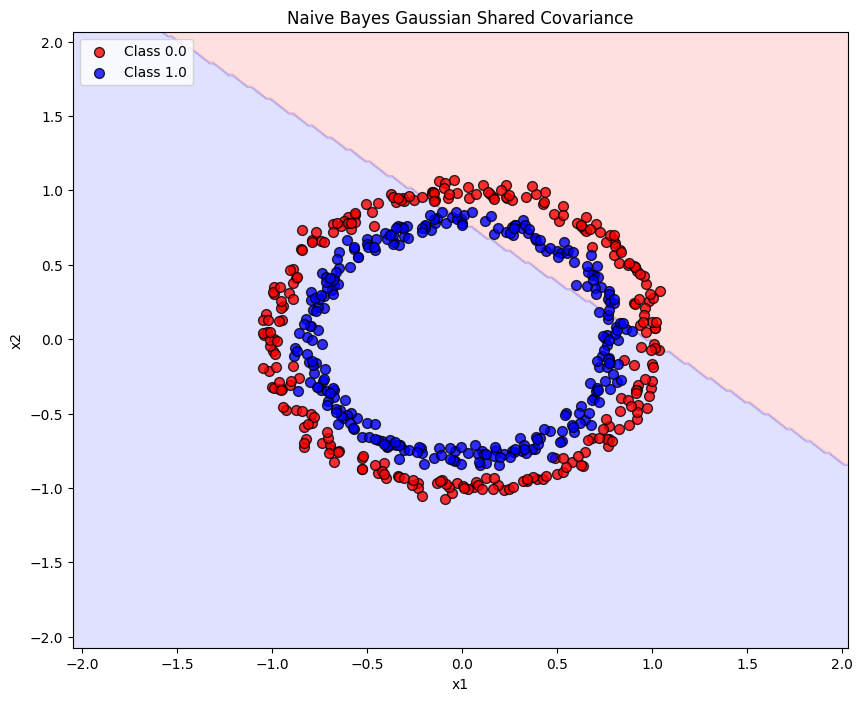

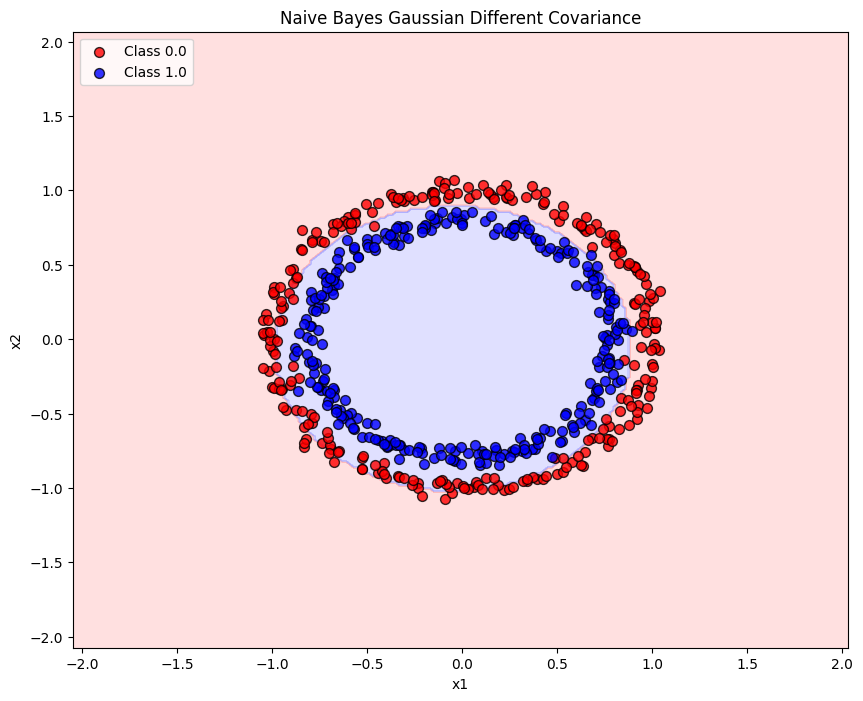

In [10]:
#DATASET 2 NAIVE BAYES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class NaiveBayesClassifier:
    def __init__(self, shared_variance=False):
        self.shared_variance = shared_variance
        self.classes = None
        self.means = None
        self.variances = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0)
            self.priors[idx] = len(X_c) / len(X)
        
        if self.shared_variance:
            self.variances = np.mean(self.variances, axis=0)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            posterior = prior
            
            if self.shared_variance:
                var = self.variances
            else:
                var = self.variances[idx]
            
            posterior += np.sum(self._log_gaussian_pdf(x, self.means[idx], var))
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    def _log_gaussian_pdf(self, x, mean, var):
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2) / var


    def probability_density(self, X):
        densities = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            if self.shared_variance:
                cov = self.variances
            else:
                cov = self.variances[idx]
            densities[:, idx] = multivariate_normal.pdf(X, mean=self.means[idx], cov=cov)
        return densities

    def print_covariance(self):
        if self.variances is None:
            print("The classifier hasn't been fitted yet. Please call fit() first.")
            return

        if self.shared_variance:
            print("Shared Covariance Matrix:")
            print(self.variances)
        else:
            print("Covariance Matrices for each class:")
            for idx, c in enumerate(self.classes):
                print(f"Class {c}:")
                print(self.variances[idx])
                print()

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y

def plot_decision_regions(classifier, X, y, resolution=0.02):
    colors = ['#FF0000', '#0000FF', ]  
    complementary_colors = ['#FF9999', '#9999FF', ]  
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Create custom colormap for the background
    cmap = ListedColormap(complementary_colors)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Calculate probability densities for level curves
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    densities = classifier.probability_density(X_grid)
    
    #Plot level curves for each class
    # for idx in range(len(classifier.classes)):
    #     Z = densities[:, idx].reshape(xx1.shape)
    #     levels = np.linspace(Z.min(), Z.max(), 7)
    #     plt.contour(xx1, xx2, Z, levels=levels, colors=colors[idx], alpha=0.5, linestyles='dashed',linewidths=2)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    edgecolor='black',
                    marker='o',  # Circular marker
                    s=50,  # Marker size
                    label=f'Class {cl:.1f}')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='upper left')
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    plt.title('Decision Region Plot with Level Curves')


# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-2/Train.csv')
X_test, y_test = load_data('./team20/Dataset-2/Train.csv')





# Create and train the classifiers
classifier_shared = NaiveBayesClassifier(shared_variance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = NaiveBayesClassifier(shared_variance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
plt.figure(figsize=(10, 8))

# plt.subplot(131)
plot_decision_regions(classifier_shared, X_train, y_train)
plt.title('Naive Bayes Gaussian Shared Covariance')
plt.savefig("./d2-naive-shared.svg", format="svg", dpi=300)

# plt.subplot(132)
plt.figure(figsize=(10, 8))
plot_decision_regions(classifier_different, X_train, y_train)
plt.title('Naive Bayes Gaussian Different Covariance')
plt.savefig("./d2-naive-different.svg", format="svg", dpi=300)




#------------




# #Confusion matrices
# cm_shared = confusion_matrix(y_test, y_pred_shared)
# cm_different = confusion_matrix(y_test, y_pred_different)

# plt.figure(figsize=(5, 5))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix for Train (Naive Bayes, Shared Covariance)')
# plt.tight_layout()
# plt.savefig("./d2-naive-cm-train-shared.svg", format="svg", dpi=300)

# # Plot confusion matrix for different covariances
# plt.figure(figsize=(5, 5))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix for Train (Naive Bayes, Different Covariances)')
# plt.savefig("./d2-naive-cm-train-different.svg", format="svg", dpi=300)


In [8]:
#COVARIANCE MATRIX
classifier_shared.print_covariance()
classifier_different.print_covariance()

Shared Covariance Matrix:
[0.40899768 0.41580127]
Covariance Matrices for each class:
Class 0.0:
[0.49998137 0.50632346]

Class 1.0:
[0.31801398 0.32527909]



Training Data:
 Accuracy (Shared Covariance): 0.5375
 Accuracy (Different Covariances): 0.9125


<Figure size 500x500 with 0 Axes>

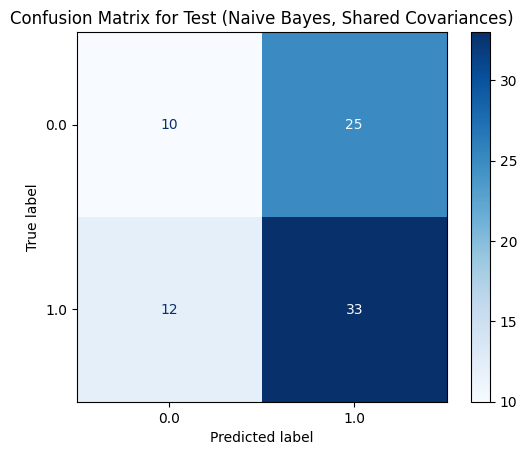

<Figure size 500x500 with 0 Axes>

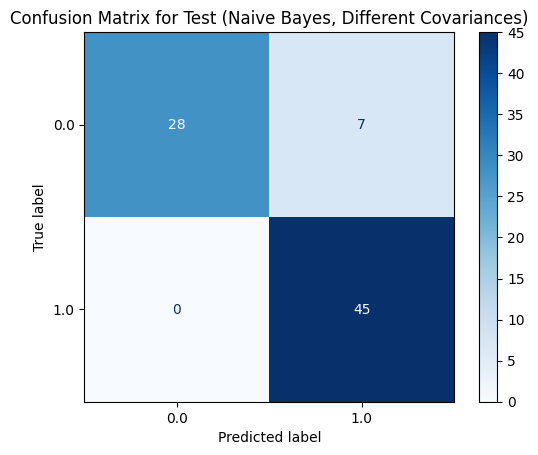

In [11]:

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-2/Train.csv')
X_test, y_test = load_data('./team20/Dataset-2/Test.csv')





# Create and train the classifiers
classifier_shared = NaiveBayesClassifier(shared_variance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = NaiveBayesClassifier(shared_variance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
# plt.figure(figsize=(10, 8))

# plot_decision_regions(classifier_shared, X_train, y_train)
# plt.title('Shared Covariance')


# plt.figure(figsize=(10, 8))
# plot_decision_regions(classifier_different, X_train, y_train)
# plt.title('Different Covariances')



#------------




#Confusion matrices
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues, )
plt.title('Confusion Matrix for Test (Naive Bayes, Shared Covariances)')
plt.savefig("./d2-naive-cm-test-shared.svg", format="svg", dpi=300)

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test (Naive Bayes, Different Covariances)')
plt.savefig("./d2-naive-cm-test-different.svg", format="svg", dpi=300)


Training Data:
 Accuracy (Shared Covariance): 0.4591
 Accuracy (Different Covariances): 0.8239


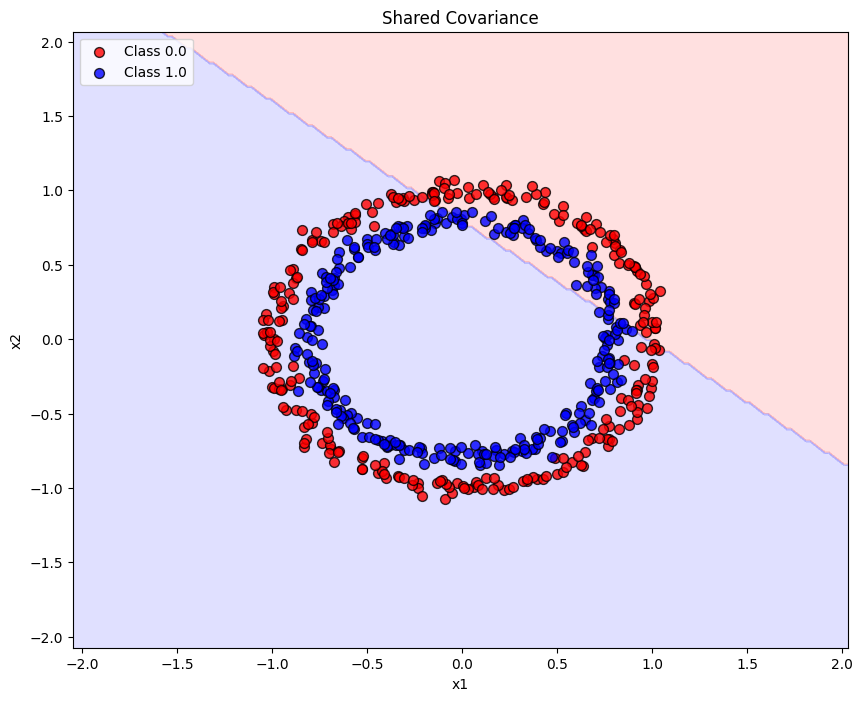

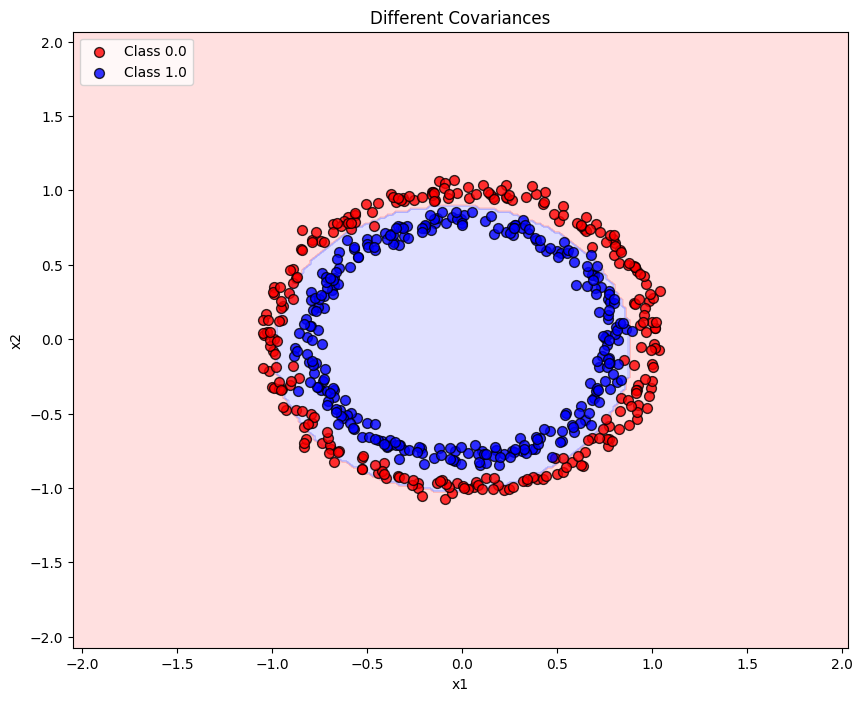

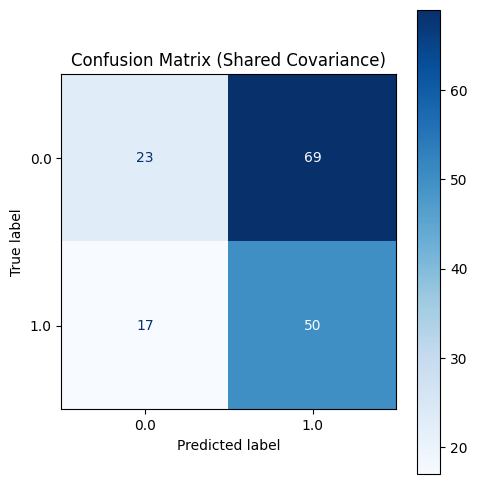

<Figure size 500x500 with 0 Axes>

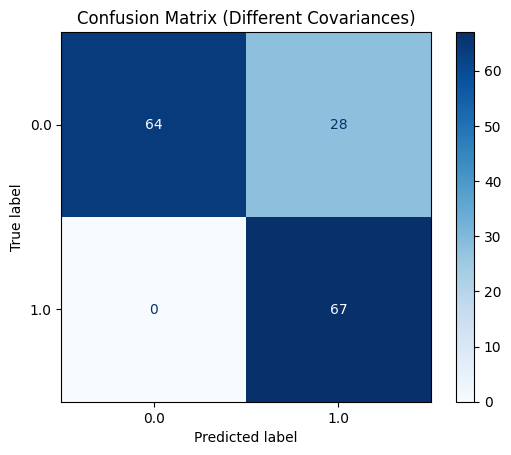

In [12]:

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-2/Train.csv')
X_test, y_test = load_data('./team20/Dataset-2/Val.csv')





# Create and train the classifiers
classifier_shared = NaiveBayesClassifier(shared_variance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = NaiveBayesClassifier(shared_variance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
plt.figure(figsize=(10, 8))

plot_decision_regions(classifier_shared, X_train, y_train)
plt.title('Shared Covariance')


plt.figure(figsize=(10, 8))
plot_decision_regions(classifier_different, X_train, y_train)
plt.title('Different Covariances')



#------------




#Confusion matrices
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix (Shared Covariance)')
plt.tight_layout()
plt.show()

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Different Covariances)')
plt.show()
